In [1]:
#https://github.com/pomber/covid19
print('Initializing brazilian analysis!')
import numpy as np
import pandas as pd
import folium, html, json
import matplotlib.pyplot as plt
import datetime

Initializing brazilian analysis!


In [2]:
df = pd.read_csv('../data/brazil_corona19_data.csv')
df['date'] = df['date'].astype('datetime64[ns]')

today = df.date.max().date()
tomorrow = today + datetime.timedelta(days=1)
yesterday = today - datetime.timedelta(days=1)
qtdeMonitored = 10

df = df[(df['state']!='-') & (df['codmun']==0)]

df.tail()

,region,state,city,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,date,semanaEpi,population,...,avg7_cases,avg7_deaths,avg7_recoveries,perc_death,avg7_perc_death,avg7_case_day_thousand,avg7_death_day_thousand,avg7_recovery_day_thousand,perc_recovery,active_cases
2230,Centro-Oeste,DF,-,53,0.0,0.0,-,2020-05-27,22,3015268.0,...,371.0,8.0,0.0,1.71,1.60,0.123,0.003,0.0,0.0,7628.0
2231,Centro-Oeste,DF,-,53,0.0,0.0,-,2020-05-28,22,3015268.0,...,394.0,8.0,0.0,1.71,1.63,0.131,0.003,0.0,0.0,8158.0
2232,Centro-Oeste,DF,-,53,0.0,0.0,-,2020-05-29,22,3015268.0,...,396.0,9.0,0.0,1.77,1.66,0.131,0.003,0.0,0.0,8568.0
2233,Centro-Oeste,DF,-,53,0.0,0.0,-,2020-05-30,22,3015268.0,...,460.0,9.0,0.0,1.71,1.69,0.153,0.003,0.0,0.0,9312.0
2234,Centro-Oeste,DF,-,53,0.0,0.0,-,2020-05-31,23,3015268.0,...,448.0,9.0,0.0,1.74,1.72,0.149,0.003,0.0,0.0,9610.0


In [3]:
state_geo = json.load(open('../data/brasil-estados.json'))
df_mapa = df[(df['date']==str(today)) & (df['codmun']==0) & (df['state']!='-')].copy()
states = df_mapa.state.unique()

for state in state_geo['features']: 
    latLon =  state['properties']['centroide']
    codarea = state['properties']['codarea']
    df_mapa.loc[df_mapa['coduf']==int(codarea),'lat'] = latLon[1]
    df_mapa.loc[df_mapa['coduf']==int(codarea),'lon'] = latLon[0]

df_mapa.tail()

,region,state,city,coduf,codmun,codRegiaoSaude,nomeRegiaoSaude,date,semanaEpi,population,...,avg7_recoveries,perc_death,avg7_perc_death,avg7_case_day_thousand,avg7_death_day_thousand,avg7_recovery_day_thousand,perc_recovery,active_cases,lat,lon
1918,Sul,RS,-,43,0.0,0.0,-,2020-05-31,23,11377239.0,...,0.0,2.40,2.70,0.036,0.001,0.0,0.0,9108.0,-29.705809,-53.319974
1995,Centro-Oeste,MS,-,50,0.0,0.0,-,2020-05-31,23,2778986.0,...,0.0,1.34,1.45,0.029,0.000,0.0,0.0,1469.0,-20.327475,-54.845564
2068,Centro-Oeste,MT,-,51,0.0,0.0,-,2020-05-31,23,3484466.0,...,0.0,2.51,2.58,0.040,0.001,0.0,0.0,2368.0,-12.948919,-55.911975
2148,Centro-Oeste,GO,-,52,0.0,0.0,-,2020-05-31,23,7018354.0,...,0.0,3.35,3.65,0.026,0.001,0.0,0.0,3578.0,-16.042109,-49.623608
2234,Centro-Oeste,DF,-,53,0.0,0.0,-,2020-05-31,23,3015268.0,...,0.0,1.74,1.72,0.149,0.003,0.0,0.0,9610.0,-15.780746,-47.797341


In [4]:
m = folium.Map(location=[-15.75, -49.95], zoom_start=4)
df_mapa.coduf = df_mapa.coduf.astype('str') # para o mappgin

# folium.Choropleth(
#     geo_data=state_geo,
#     name='Contaminações',
#     data=df_brasil,
#     columns=['id_estado', 'avg7_cases'],
#     key_on='feature.properties.codarea',
#     fill_color='PuBu',#'YlGn',
#     fill_opacity=0.7,
#     line_opacity=0.3,
#     legend_name='media movel de casos (7 ultimos dias)'
# ).add_to(m)

folium.Choropleth(
    geo_data=state_geo,
    name='Mortes por mil habitantes',
    data=df_mapa,
    columns=['coduf', 'death_day_thousand'],
    key_on='feature.properties.codarea',
    fill_color='YlOrRd',#'YlGn',
#     ‘BuGn’, ‘BuPu’, ‘GnBu’, ‘OrRd’, ‘PuBu’, ‘PuBuGn’, ‘PuRd’, ‘RdPu’, ‘YlGn’, ‘YlGnBu’, ‘YlOrBr’, and ‘YlOrRd’.
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name= 'mortes em ' + today.strftime("%d/%m/%Y") + ' por mil habitandes'
).add_to(m)

for state in states:
    dados = df_mapa[df_mapa['state']==state]
    detalhes = '<center><b>'+dados.state.values[0] +'</b></center>\n'
    detalhes += 'casos: ' + str(dados.cases.sum()) + ', mortes: ' + str(dados.deaths.sum())
    detalhes += ', mortes/1k hab: ' + str(dados.deaths_thousand.values[0])
    
    folium.CircleMarker(
        location=[dados.lat,dados.lon],
        radius=5,
#         popup=detalhes,
        color='#727b7d',
        fill=True,
        fill_color='black',
        tooltip=detalhes,
        icon=folium.Icon(color='blue',
             icon_color='black',
             icon='info-sign',
             prefix='es')
    ).add_to(m)

folium.LayerControl().add_to(m)

m.save('../analysis/maps/brazilMapDeaths.html')
m

In [5]:
m = folium.Map(location=[-15.75, -49.95], zoom_start=4)
folium.Choropleth(
    geo_data=state_geo,
    name='Contaminações por mil habitantes',
    data=df_mapa,
    columns=['coduf', 'case_day_thousand'],
    key_on='feature.properties.codarea',
    fill_color='RdPu',#'YlGn',
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name= 'casos em ' + today.strftime("%d/%m/%Y") + ' por mil habitantes',
).add_to(m)
folium.LayerControl().add_to(m)

for state in states:
    dados = df_mapa[df_mapa['state']==state]
    detalhes = '<center><b>'+dados.state.values[0] +'</b></center>\n'
    detalhes += 'casos: ' + str(dados.cases.sum()) + ', mortes: ' + str(dados.deaths.sum())
    detalhes += ', casos/1k hab: ' + str(dados.cases_thousand.values[0])
    
#     detalhes = udetalhes
    
    folium.CircleMarker(
        location=[dados.lat,dados.lon],
        radius=5,
#         popup=detalhes,
        color='#727b7d',
        fill=True,
        fill_color='blue',
        tooltip=detalhes,
        icon=folium.Icon(color='blue',
             icon_color='black',
             icon='info-sign',
             prefix='es')
    ).add_to(m)
    
m.save('../analysis/maps/brazilMapCases.html')
m

In [6]:
# import imgkit
# print('Gerando imagens dos mapas do Brasil')
# options = {
#     'format': 'png',
# #     'crop-h': '3',
# #     'crop-w': '3',
# #     'crop-x': '3',
# #     'crop-y': '3',
#     'width':'300',
#     'encoding': "UTF-8",
#     'custom-header' : [
#         ('Accept-Encoding', 'gzip')
#     ],
# }
# imgkit.from_file('../analysis/maps/brazilMapDeathsContainer.html', '../analysis/maps/brazilMapDeaths.png', options=options)
# imgkit.from_file('../analysis/maps/brazilMapCasesContainer.html', '../analysis/maps/brazilMapCases.png', options=options)

----------------------------
### Brasil - Analysis and monitoring

In [7]:
#week variation
lastWeek = today - datetime.timedelta(days=7)

# cases and deaths
lastWeekCases = df[df['date']==str(lastWeek)].cases.sum()
lastWeekDeaths = df[df['date']==str(lastWeek)].deaths.sum()
todayCases = df[df['date']==str(today)].cases.sum()
todayDeaths = df[df['date']==str(today)].deaths.sum()
varCases = int((todayCases / lastWeekCases - 1) *100)
varDeaths = int((todayDeaths / lastWeekDeaths - 1) *100)
diffCases = todayCases - lastWeekCases
diffDeaths = todayDeaths - lastWeekDeaths

#### Top 5 deadliest states 

In [8]:
cols = ['state', 'date', 'day', 'population','case_day', 'cases', 'death_day', 'deaths', 'cases_thousand','deaths_thousand', 'perc_death']

df_top_deaths = df[(df['date']==str(today))].sort_values('deaths_thousand', ascending = False)
df_top_deaths.reset_index(0, inplace=True)
df_top_deaths.index = df_top_deaths.index + 1
df_top_deaths = df_top_deaths[cols].head(qtdeMonitored)
df_top_deaths

,state,date,day,population,case_day,cases,death_day,deaths,cases_thousand,deaths_thousand,perc_death
1,AM,2020-05-31,78,4144597.0,818,41378,5,2052,9.984,0.495,4.96
2,PA,2020-05-31,74,8602865.0,665,37961,23,2923,4.413,0.340,7.70
3,CE,2020-05-31,76,9132078.0,1983,48489,54,3010,5.310,0.330,6.21
4,RJ,2020-05-31,88,17264943.0,968,53388,67,5344,3.092,0.310,10.01
5,PE,2020-05-31,81,9557071.0,1023,34450,67,2807,3.605,0.294,8.15
6,AP,2020-05-31,73,845731.0,289,9602,7,222,11.353,0.262,2.31
7,RR,2020-05-31,71,605761.0,175,3474,6,116,5.735,0.191,3.34
8,AC,2020-05-31,74,881935.0,147,6219,6,148,7.052,0.168,2.38
9,SP,2020-05-31,96,45919049.0,2556,109698,83,7615,2.389,0.166,6.94
10,ES,2020-05-31,87,4018650.0,253,13690,21,604,3.407,0.150,4.41


#### Top 5 most transmissible countries + Brazil

In [9]:
df_top_cases = df[(df['date']==str(today))].sort_values('cases_thousand', ascending = False)

df_top_cases.reset_index(0, inplace=True)
df_top_cases.index = df_top_cases.index + 1
df_top_cases = df_top_cases[cols].head(qtdeMonitored)
df_top_cases

,state,date,day,population,case_day,cases,death_day,deaths,cases_thousand,deaths_thousand,perc_death
1,AP,2020-05-31,73,845731.0,289,9602,7,222,11.353,0.262,2.31
2,AM,2020-05-31,78,4144597.0,818,41378,5,2052,9.984,0.495,4.96
3,AC,2020-05-31,74,881935.0,147,6219,6,148,7.052,0.168,2.38
4,RR,2020-05-31,71,605761.0,175,3474,6,116,5.735,0.191,3.34
5,CE,2020-05-31,76,9132078.0,1983,48489,54,3010,5.310,0.330,6.21
6,MA,2020-05-31,72,7075181.0,2019,34639,23,955,4.896,0.135,2.76
7,PA,2020-05-31,74,8602865.0,665,37961,23,2923,4.413,0.340,7.70
8,PE,2020-05-31,81,9557071.0,1023,34450,67,2807,3.605,0.294,8.15
9,ES,2020-05-31,87,4018650.0,253,13690,21,604,3.407,0.150,4.41
10,PB,2020-05-31,74,4018127.0,300,13162,13,360,3.276,0.090,2.74


#### Brazilian states to be analised

#### Cases and deaths 

In [10]:
#inform the countries you want to analise
monitoredStates = df_top_deaths['state'].head(qtdeMonitored).to_numpy()
monitoredStates

array(['AM', 'PA', 'CE', 'RJ', 'PE', 'AP', 'RR', 'AC', 'SP', 'ES'],
      dtype=object)

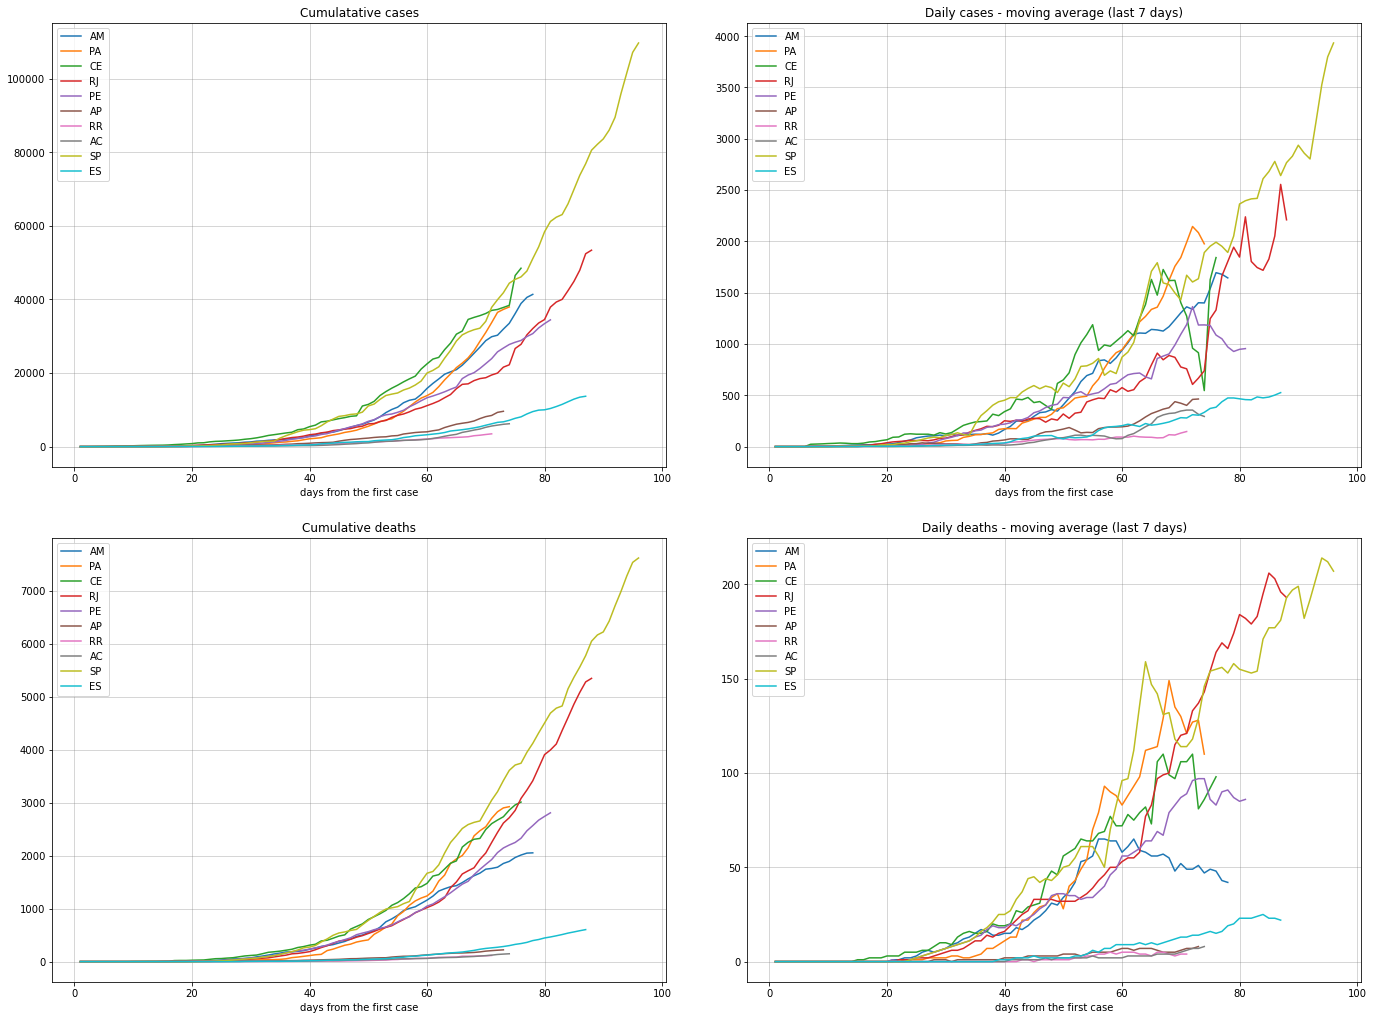

In [11]:
# fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(20, 20))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

ax1.set_title("Cumulatative cases")
ax1.set_xlabel("days from the first case")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("Daily cases - moving average (last 7 days)")
ax2.set_xlabel("days from the first case")
ax2.grid(color='gray', alpha = 0.4)

ax3.set_title("Cumulative deaths")
ax3.set_xlabel("days from the first case")
ax3.grid(color='gray', alpha = 0.4)

ax4.set_title("Daily deaths - moving average (last 7 days)")
ax4.set_xlabel("days from the first case")
ax4.grid(color='gray', alpha = 0.4)

# ax5.set_title("Cumulative recoveries")
# ax5.set_xlabel("days from the first case")
# ax5.grid(color='gray', alpha = 0.4)

# ax6.set_title("Recoveries - moving average (last 7 days)")
# ax6.set_xlabel("days from the first case")
# ax6.grid(color='gray', alpha = 0.4)

for state in monitoredStates:
    dados = df[(df['state'] == state) & (df['codmun']==0)]
    ax1.plot(dados.day, dados.cases, label = state)
    ax2.plot(dados.day, dados.avg7_cases, label = state)
    ax3.plot(dados.day, dados.deaths, label = state)
    ax4.plot(dados.day, dados.avg7_deaths, label = state)
#     ax5.plot(df[indexes].day, df[indexes].recoveries, label = state)
#     ax6.plot(df[indexes].day, df[indexes].avg7_recoveries, label = state)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
# ax5.legend()
# ax6.legend()
fig.savefig('../analysis/brazilian_states_cases_deaths.png')

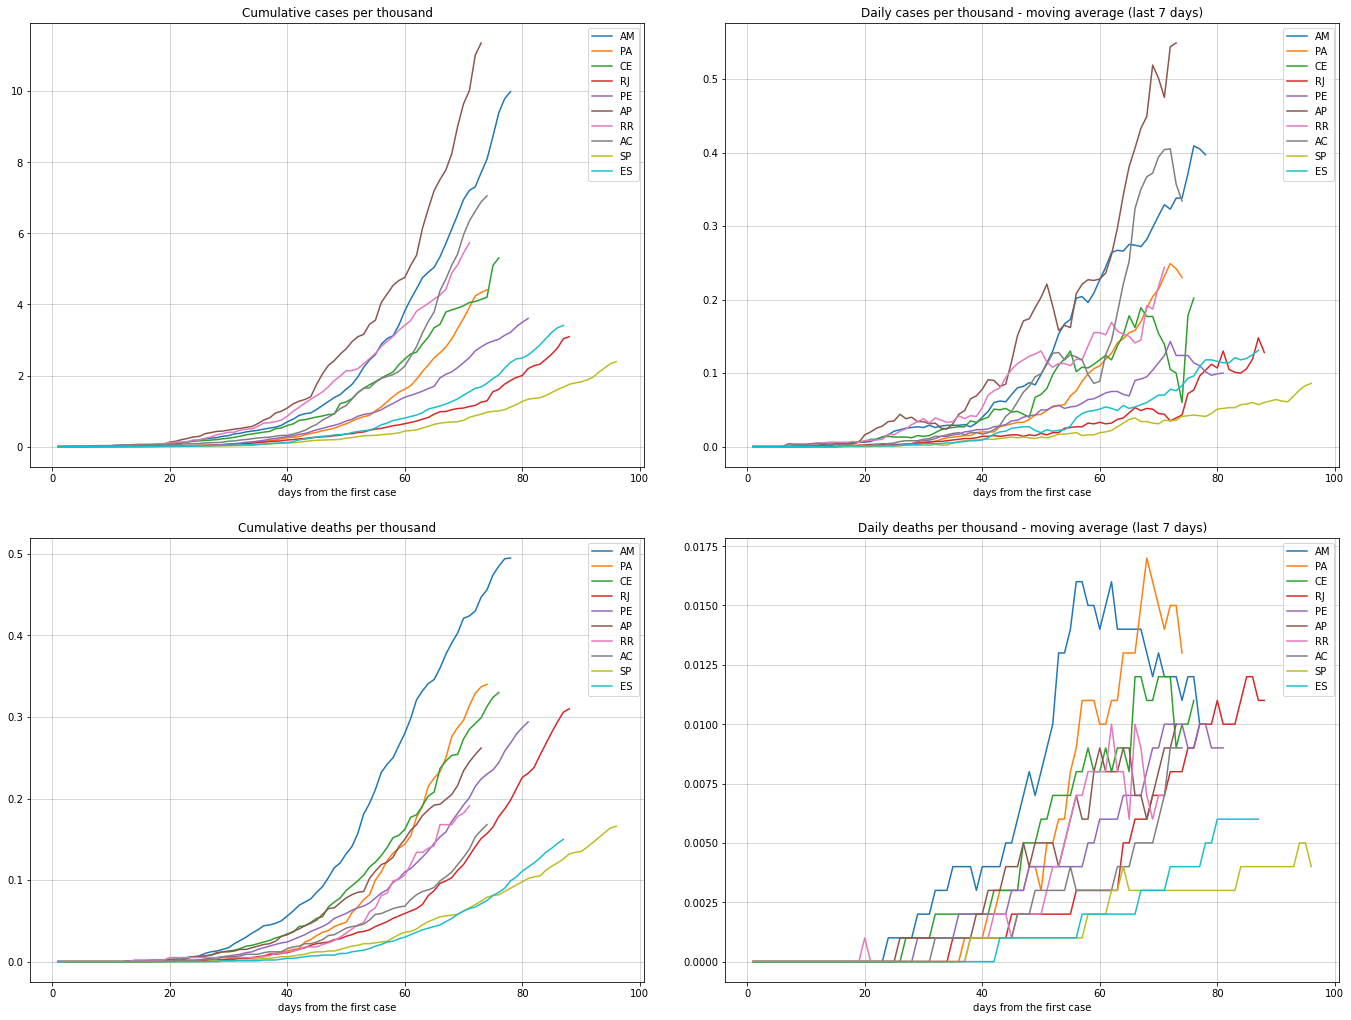

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20, 15))
fig.tight_layout(pad=5.0)

ax1.set_title("Cumulative cases per thousand")
ax1.set_xlabel("days from the first case")
ax1.grid(color='gray', alpha = 0.4)

ax2.set_title("Daily cases per thousand - moving average (last 7 days)")
ax2.set_xlabel("days from the first case")
ax2.grid(color='gray', alpha = 0.4)

ax3.set_title("Cumulative deaths per thousand")
ax3.set_xlabel("days from the first case")
ax3.grid(color='gray', alpha = 0.4)

ax4.set_title("Daily deaths per thousand - moving average (last 7 days)")
ax4.set_xlabel("days from the first case")
ax4.grid(color='gray', alpha = 0.4)

# ax5.set_title("Recoveries per thousand")
# ax5.set_xlabel("days from the first case")
# ax5.grid(color='gray', alpha = 0.4)

# ax6.set_title("Recoveries per thousand - moving average (last 7 days)")
# ax6.set_xlabel("days from the first case")
# ax6.grid(color='gray', alpha = 0.4)

for state in monitoredStates:
    dados = df[(df['state'] == state) & (df['codmun']==0)]
    ax1.plot(dados.day, dados.cases_thousand, label = state)
    ax2.plot(dados.day, dados.avg7_case_day_thousand, label = state)
    ax3.plot(dados.day, dados.deaths_thousand, label = state)
    ax4.plot(dados.day, dados.avg7_death_day_thousand, label = state)
#     ax5.plot(df[indexes].day, df[indexes].recoveries_thousand, label = state)
#     ax6.plot(df[indexes].day, df[indexes].avg7_recoveries_thousand, label = state)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
# ax5.legend()
# ax6.legend()

fig.savefig('../analysis/brazil_cases_deaths_thousand.png')

### Generating the HTML file

In [13]:
f = open('../html/brazil_analysis.html', 'w')
f1 = open('../html/templates/brazil_analysis_01.html', 'r').read()
f2 = open('../html/templates/brazil_analysis_02.html', 'r').read()
f3 = open('../html/templates/brazil_analysis_03.html', 'r').read()

readme = f1
readme += '<p>Estas análises são relativas aos dados da pandemia Covid19 no Brasil até a data de <strong>' + today.strftime("%d/%m/%Y") + '</strong>.</p>'
readme += '          <p style="font-size:14px"><i>Estas informações são para uso próprio e não devem ser utilizadas para direcionamentos médicos e/ou políticas públicas.</i></p>'
readme += '</div></div>'
readme += '<div class="container"> '
readme += '<h3>Análise semanal</h3><br>'
readme += '<table border="1" class="dataframe " width="60%">'
readme += '  <thead>'
readme += '    <tr>'
readme += '      <th style="text-align: center;" width="25%"></th>'
readme += '      <th style="text-align: center;">'+ lastWeek.strftime("%d/%m/%Y")+ '</th>'
readme += '      <th style="text-align: center;">'+ today.strftime("%d/%m/%Y") +'</th>'
readme += '      <th style="text-align: center;"> variação </th>'
readme += '    </tr>'
readme += '  </thead>'
readme += '  <tbody>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: right;" width="25%">casos</td>'
readme += '      <td>'+str(lastWeekCases)+'</td>'
readme += '      <td>'+str(todayCases)+'</td>'
readme += '      <td>'+str(diffCases)+ ' (' +str(varCases)+'%)</td>'
readme += '    </tr>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: right;" width="25%">mortes</td>'
readme += '      <td>'+str(lastWeekDeaths)+'</td>'
readme += '      <td>'+str(todayDeaths)+'</td>'
readme += '      <td>'+str(diffDeaths)+ ' ('+str(varDeaths)+'%)</td>'
readme += '    </tr>'
readme += '  </tbody>'
readme += '</table> </div><br>' 
readme += f2
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' estados mais mortais do Brasil</h3>'
readme += '          <p>O ranking é feito a partir da quantidade total de mortes por cada mil habitantes de cada estado.</p>'
readme += df_top_deaths.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' estados mais transmissíveis do Brasil</h3>'
readme += '          <p>O ranking é feito a partir da quantidade total de casos por cada mil habitantes de cada estado.</p>'
readme += df_top_cases.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += f3

f.write(readme)
f.close()

###########################################

f = open('../html/brazil_analysis_EN.html', 'w')
f1 = open('../html/templates/brazil_analysis_EN_01.html', 'r').read()
f2 = open('../html/templates/brazil_analysis_EN_02.html', 'r').read()
f3 = open('../html/templates/brazil_analysis_EN_03.html', 'r').read()

readme = f1
readme += '<p>These analysis are related to Brazil Convid19 pandemic data up to <strong>' + today.strftime("%m/%d/%Y") + '</strong>.</p>'
readme += '             <p style="font-size:14px"><i>This information is for own use only and shall NOT be used for medical and public policy guidances.</i></p>'
readme += '</div></div>'
readme += '<div class="container"> '
readme += '<h3>Weekly analysis</h3><br>'
readme += '<table border="1" class="dataframe " width="60%">'
readme += '  <thead>'
readme += '    <tr>'
readme += '      <th style="text-align: center;" width="25%"></th>'
readme += '      <th style="text-align: center;">'+ lastWeek.strftime("%d/%m/%Y")+ '</th>'
readme += '      <th style="text-align: center;">'+ today.strftime("%d/%m/%Y") +'</th>'
readme += '      <th style="text-align: center;"> variations </th>'
readme += '    </tr>'
readme += '  </thead>'
readme += '  <tbody>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: right;" width="25%">cases</td>'
readme += '      <td>'+str(lastWeekCases)+'</td>'
readme += '      <td>'+str(todayCases)+'</td>'
readme += '      <td>'+str(diffCases)+ ' (' +str(varCases)+'%)</td>'
readme += '    </tr>'
readme += '    <tr style="text-align: right;">'
readme += '      <td style="font-weight: bold; text-align: right;" width="25%">deaths</td>'
readme += '      <td>'+str(lastWeekDeaths)+'</td>'
readme += '      <td>'+str(todayDeaths)+'</td>'
readme += '      <td>'+str(diffDeaths)+ ' ('+str(varDeaths)+'%)</td>'
readme += '    </tr>'
readme += '  </tbody>'
readme += '</table> </div><br>' 
readme += f2
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' deadliest states of Brazil</h3>'
readme += '          <p>This ranking is made from the total of deaths per each thousand of population of each state.</p>'
readme += df_top_deaths.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += '        <div class="container">'
readme += '          <h3>Top ' + str(qtdeMonitored) + ' most transmissible states of Brazil</h3>'
readme += '          <p>This ranking is made from the total of cases per each thousand of population of each state.</p>'
readme += df_top_cases.to_html(classes='table', decimal=',', justify='justify')
readme += '        </div>'
readme += '        <br>'
readme += f3

f.write(readme)
f.close()

print('Brazilian analysis done!')

Brazilian analysis done!


In [14]:
# df[df['state']=='SP'][['date','death_day']]